# 2. Monolithic AD & ML Approaches and Why They are Unsatisfactory

Given the abundance of normal driving data, the problem naturally leads to an anomaly detection (AD) formulation. Let’s try some off-the-shell well-known methods for example Isolation Forest!

In theory, AD approach isn't affected by the Cold Start problem as training data is normal data only, and is hence we only need labels during evaluation of the intrusion detection system.

But will it work accurately enough? Let's try!

### 2a. A naive AD approach using IsolationForest

In [518]:
df_train = pd.read_parquet("s3://h1st-tutorial-autocyber/attack-samples/20181203_Driver1_Trip10-0.parquet")

df_train[df_train.AttackEventIndex==1]

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label,AttackSensor,AttackMethod,AttackParams,AttackEventIndex
67533,314.563268,2.423742,NaN,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
67534,314.563634,NaN,NaN,0.209293,-0.353006,-0.026075,Normal,NA,NA,0.000000,1
67535,314.566763,NaN,NaN,33.217717,NaN,NaN,Attack,YawRate,const,32.684679,1
67536,314.573020,NaN,20.6472,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
67537,314.575819,2.402111,NaN,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
72248,331.000073,NaN,NaN,34.190951,NaN,NaN,Attack,YawRate,const,32.684679,1
72249,331.012296,NaN,NaN,33.219857,NaN,NaN,Attack,YawRate,const,32.684679,1
72250,331.024601,NaN,NaN,33.077790,NaN,NaN,Attack,YawRate,const,32.684679,1
72251,331.036546,NaN,NaN,33.166474,NaN,NaN,Attack,YawRate,const,32.684679,1


Here we include timing-based features, such as time diff since last message of the same type. 

Also, we need to handle the NaN values due to the unique feature of CAN bus data, i.e. YawRate/Gx/Gy is a different CAN message than SteeringAngle or CarSpeed.

In [515]:
def compute_timediff_fillna(df):
    df = df.copy()
    for s in SENSORS:
        sensor_not_isna = df[~df[s].isna()]
        df["%s_TimeDiff" % s] = sensor_not_isna.Timestamp - sensor_not_isna.shift(1).Timestamp
    #print(df.head(20))

    for s in SENSORS:
        df[s] = df[s].fillna(method="ffill")
        df["%s_TimeDiff" % s] = df["%s_TimeDiff" % s].fillna(method="ffill")
    df.dropna(subset=FEATURES, inplace=True)
    
    return df

df_train_filled = compute_timediff_fillna(df_train)

In [516]:
from sklearn.ensemble import IsolationForest
import sklearn.metrics

FEATURES = SENSORS + ["%s_TimeDiff" % s for s in SENSORS]

iforest = IsolationForest(n_estimators=500).fit(df_train_filled[FEATURES])

In [520]:
import numpy as np

df_test = pd.read_parquet("s3://h1st-tutorial-autocyber/attack-samples/20181203_Driver1_Trip10-1.parquet")
df_test_filled = compute_timediff_fillna(df_test)

ypred = iforest.predict(dfb[FEATURES])

ypred = pd.Series(np.maximum(-ypred, 0)) # iforest predict -1 vs 1, we need 0 vs 1
cf = sklearn.metrics.confusion_matrix(dfb.Label == "Attack", ypred)
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(dfb.Label =="Attack", ypred))

[[251891  38204]
 [  3497   8272]]
Accuracy = 0.8618550075530702 


This is certainly a start. But the accuracy is no where near what’s needed for deployment!

While there are a lot of exciting approaches for AD and sequential time-series data, including using RNN/LSTM/CNN, autoencoders, self-supervised learning, etc. The fundamental problem with AD is that it is hard to achieve high TPR while simultaneously achieving very low FPR.

Since AD after all, is a harder problem than supervised learning and while they are important parts of the tool box, we still need final human clearance to key system decisions.

### 2b. Machine teaching: leveraging ML to "program" a classifier by specifying human-generated outputs

If we zoom in, it is perhaps easier to see the zig-zag patterns of alternating real vs injected messages. It's clear that perhaps we can leverage a ML to classify these kinds of smooth vs zig-zag patterns.

After all, ML should excel at pattern recognition.

The significance of this approach is that it is much easier for human experts to synthesize the attack data than to write the detection program. And such is the promise of Software 2.0, but will it work?

Let's inspect closely one such attack event.

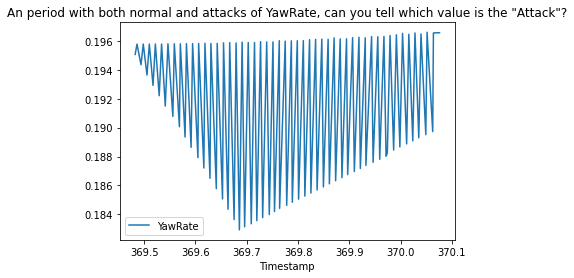

In [497]:
z = df_attacks[0][df_attacks[0].AttackEventIndex==2]
z = z[~z.YawRate.isna()].set_index("Timestamp")

import matplotlib.pyplot as plt
z.iloc[:100].YawRate.plot(label="YawRate")
plt.title('An period with both normal and attacks of YawRate, can you tell which value is the "Attack"?')
plt.legend()
plt.show()

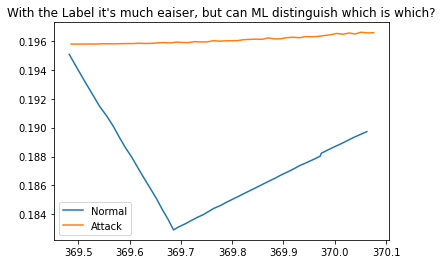

In [498]:
import matplotlib.pyplot as plt
plt.figure()
z = z.iloc[:100].reset_index() # pop Timestamp attribute
znorm = z[z.Label == "Normal"]
plt.plot(znorm.Timestamp, znorm.YawRate, label="Normal")
zattk = z[z.Label == "Attack"]
plt.plot(zattk.Timestamp, zattk.YawRate, label="Attack")
plt.legend()
plt.title("With the Label it's much eaiser, but can ML distinguish which is which?")
plt.show()

Let’s try a gradient-boosted trees firstly, e.g. sklearn’s HistGradientBoostingClassifier can work well on larger dataset before bringing out bigger guns.

In [484]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

gbc = HistGradientBoostingClassifier(max_iter=500).fit(dfa[FEATURES], dfa.Label == "Attack")

In [499]:
import numpy as np

dfb = pd.read_parquet("/Users/aht/Documents/Zenodo CAN data/attack-samples/20181114_Driver2_Trip1-0.parquet")
dfb = compute_timediff_fillna(dfb)

ypred = gbc.predict(dfb[FEATURES])

cf = sklearn.metrics.confusion_matrix(dfb.Label == "Attack", ypred)
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(dfb.Label == "Attack", ypred))

[[256486   1208]
 [  4873   6791]]
Accuracy = 0.9774240972980197 


Impressive as it seems, we must note that the false-positive rate is still a bit high at FPR = 1208/(1208+6791) = 15%.  Since CAN messages are very frequent (100-200 msgs/sec in each car), this is still no where near deployment-ready!

We can certainly improve results by tuning the model, tuning the fill-NA method, or bring out larger guns like Bidirectional LSTM or CNN or Transformers which can work well on pattern recognition problems on sequential data such as this problem. Powerful deep learning models can recognize these attack patterns well, and can be trained much faster on the full dataset which is quite large in our case.

However, we must reckon that these models, after all, are recognizing attack patterns that humans are generating and injecting artificially. While this is convenient to generate output and train the detector program a la “Software 2.0”, for our situation, because the attacks are purely synthetic, we cannot be too sure that they are learning the right things and work robustly and can be trusted to deploy in the field. It’s best to employ them in the right deployment scope, namely useful pattern recognizers.